In [1]:
import torch
import torchvision.models as models
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from PIL import Image
import os
import warnings
print(f'the version of pytorch we are using is <{torch.__version__}>')

the version of pytorch we are using is <2.3.0>


In [5]:
# Initialize and load the model
class Plant_Disease_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(weights=None)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 38)

    def forward(self, xb):
        return self.network(xb)

model_path = 'D:\\project\\running projects\\6\\Plant_AI-master\\Plant_AI-master\\Models\\plantDisease-resnet34.pth'
base_model = Plant_Disease_Model()
base_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
base_model.eval()

# Modify model to extract features
feature_extractor = nn.Sequential(*list(base_model.network.children())[:-1], nn.Flatten()) # only removed last layer
feature_extractor.eval()

# Data loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


this part is for extracting features from our images using the pretrained model that we have. (no need to run this cell if you already have the extracted features csv file)

In [6]:
dataset = datasets.ImageFolder('D:\\project\\running projects\\6\\Plant_AI-master\\Plant_AI-master\\Src\\single', transform=transform)

# Create a mapping from class indices to folder names
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# Update your DataLoader to return the file paths
def get_paths(dataset):
    return [item[0] for item in dataset.imgs]

# Adding file paths to the dataset
file_paths = get_paths(dataset)

data_loader = DataLoader([(dataset[i][0], dataset[i][1], file_paths[i]) for i in range(len(dataset))], batch_size=16, shuffle=False)

# Extract features and save to CSV
def extract_features(data_loader, feature_extractor):
    features_list = []
    labels_list = []
    file_names = []
    with torch.no_grad():
        for inputs, labels, paths in data_loader:
            outputs = feature_extractor(inputs)
            features_list.extend(outputs.numpy())
            labels_list.extend(labels.numpy())
            # Extract only the file name from the path
            file_names.extend([os.path.basename(path) for path in paths])
    return features_list, labels_list, file_names

features, labels, file_names = extract_features(data_loader, feature_extractor)

# Convert numeric labels to folder names
labels = [idx_to_class[label] for label in labels]
df = pd.DataFrame(features)
df['label'] = labels
df['file_name'] = file_names
df.to_csv('persian_features.csv', index=False)

In [2]:
# Load the CSV file
df = pd.read_csv('persian_features.csv')

# Get the number of feature vectors
num_vectors = df.shape[0]

# Get the length of each feature vector (subtract 2 because one column is the label and one column is the file name)
vector_length = df.shape[1] - 2

print("Number of feature vectors:", num_vectors)
print("Length of each feature vector:", vector_length)

Number of feature vectors: 19187
Length of each feature vector: 512


In [3]:
df

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,label,file_name
0,0.459306,15.100235,6.980717,0.021984,2.913453,19.655716,17.749865,26.404150,15.426352,14.885514,...,3.649375,12.168367,0.232123,0.034329,22.778784,15.128444,27.560097,32.111120,آلبالو,frame_0000.jpg
1,0.332267,14.769344,6.263092,0.032340,3.141601,20.084354,18.202679,27.531860,15.505185,15.458546,...,3.449976,12.020849,0.286600,0.028993,24.115297,16.186314,27.965988,33.000950,آلبالو,frame_0001.jpg
2,0.445949,14.673233,6.584012,0.026667,2.903918,19.552713,18.043327,26.854755,15.432390,15.154693,...,3.430090,12.318122,0.203715,0.028074,23.136840,16.235207,27.704042,32.632810,آلبالو,frame_0002.jpg
3,0.613422,15.894072,7.103874,0.026617,2.860146,20.676758,19.577042,28.806202,16.549490,16.006634,...,3.674508,13.340133,0.244240,0.023296,24.462963,16.964996,29.443419,34.874653,آلبالو,frame_0003.jpg
4,0.565758,15.765001,7.673642,0.009731,3.414661,20.899471,19.280878,28.236198,16.661648,16.522650,...,4.111085,13.155335,0.265194,0.030623,24.761314,17.009146,29.361069,35.012215,آلبالو,frame_0004.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19182,1.234533,40.408783,17.987991,0.000000,6.216431,49.803967,50.009390,71.791020,38.048325,41.787506,...,6.098041,26.549782,1.276162,0.000000,60.301690,35.372623,71.819340,85.466990,گیلاس,frame_0802.jpg
19183,1.055435,40.955260,17.818220,0.000000,5.701262,49.964275,50.081066,71.611510,37.600864,41.466362,...,5.773084,26.599384,1.611680,0.000000,59.138540,35.527298,72.001000,84.502180,گیلاس,frame_0803.jpg
19184,0.588253,39.701332,15.879325,0.000000,6.027879,48.144260,49.171337,69.311710,35.497528,40.238144,...,4.034985,24.142742,2.408644,0.000000,57.051617,35.970448,68.284420,81.899050,گیلاس,frame_0804.jpg
19185,1.420450,23.433733,6.453430,0.000000,1.400067,23.593222,28.194998,37.920357,19.640339,19.031487,...,2.617971,12.516594,0.807057,0.000000,30.175247,16.346468,37.159270,44.716297,گیلاس,frame_0822.jpg


### Classification

In [5]:
!pip install arabic-reshaper python-bidi


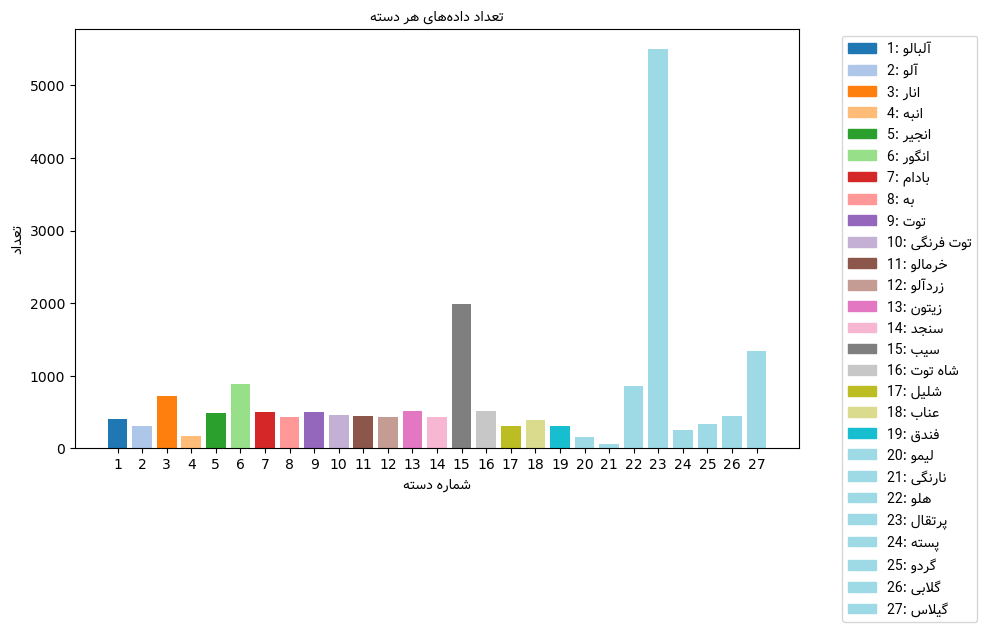

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import arabic_reshaper
from bidi.algorithm import get_display

# مسیر فونت فارسی
font_path = 'D:\\project\\running projects\\6\\Plant_AI-master\\Plant_AI-master\\Src\\Vazir.ttf'

# ساخت یک آبجکت فونت
font_prop = fm.FontProperties(fname=font_path)

# شمارش تعداد داده‌های هر برچسب بدون مرتب‌سازی
label_counts = df['label'].value_counts(sort=False)

# تخصیص شماره به هر برچسب
label_mapping = {label: i + 1 for i, label in enumerate(label_counts.index)}
numeric_labels = df['label'].map(label_mapping)

# تعریف نقشه رنگ
colors = plt.cm.tab20(range(len(label_mapping)))

# نمایش داده‌ها با رنگ‌های مختلف
plt.figure(figsize=(10, 6))
bars = plt.bar(label_mapping.values(), label_counts, color=colors)

# تغییر شکل و چیدمان متن فارسی برای عنوان و برچسب‌ها
title = get_display(arabic_reshaper.reshape('تعداد داده‌های هر دسته'))
xlabel = get_display(arabic_reshaper.reshape('شماره دسته'))
ylabel = get_display(arabic_reshaper.reshape('تعداد'))

plt.title(title, fontproperties=font_prop)
plt.xlabel(xlabel, fontproperties=font_prop)
plt.ylabel(ylabel, fontproperties=font_prop)
plt.xticks(ticks=range(1, len(label_mapping) + 1), labels=range(1, len(label_mapping) + 1), rotation=0)

# ساخت راهنما با برچسب‌های فارسی
label_mapping_sorted = dict(sorted(label_mapping.items(), key=lambda item: item[1]))
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
labels = [f"{number}: {get_display(arabic_reshaper.reshape(label))}" for label, number in label_mapping_sorted.items()]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', prop=font_prop)

plt.tight_layout()
plt.show()


In [5]:
block_size = 5  # each block contains 5 frames

# Number of blocks
num_blocks = len(df) // block_size

# Create a list of block indices
block_indices = list(range(num_blocks))

# Split the block indices into train and test sets
train_blocks, test_blocks = train_test_split(block_indices, test_size=0.2, random_state=42)

# Function to get indices from block numbers
def get_indices_from_blocks(blocks, block_size):
    indices = []
    for block in blocks:
        start_idx = block * block_size
        end_idx = start_idx + block_size
        indices.extend(range(start_idx, end_idx))
    return indices

# Get train and test indices
train_indices = get_indices_from_blocks(train_blocks, block_size)
test_indices = get_indices_from_blocks(test_blocks, block_size)

# Split the data into train and test sets
train_df = df.iloc[train_indices]
test_df = df.iloc[test_indices]

# Separate features and labels
X_train = train_df.drop(columns=['label', 'file_name'])
y_train = train_df['label']
X_test = test_df.drop(columns=['label', 'file_name'])
y_test = test_df['label']
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Verify the splits
print(f"Train set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")


Train set size: 15345
Test set size: 3840


In [6]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_scaled, y_train)

y_pred_nb = nb_classifier.predict(X_test_scaled)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print("Accuracy:", nb_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_nb, zero_division=0))
# print(len(X_test[0]))



Accuracy: 0.29270833333333335
Classification Report:
               precision    recall  f1-score   support

      آلبالو       0.62      0.05      0.09        98
         آلو       0.03      0.10      0.05        42
        انار       0.20      0.06      0.09       210
        انبه       0.58      0.92      0.72        53
       انجیر       0.13      0.66      0.21       107
       انگور       0.12      0.12      0.12       195
       بادام       0.39      0.11      0.17        65
          به       0.22      0.11      0.14        75
         توت       0.27      0.11      0.15       120
   توت فرنگی       0.16      0.90      0.27        70
      خرمالو       0.14      0.38      0.20        90
      زردآلو       0.00      0.00      0.00        75
       زیتون       0.50      0.01      0.02        95
        سنجد       0.04      0.02      0.02        65
         سیب       0.60      0.01      0.03       429
     شاه توت       0.15      0.38      0.21       116
        شلیل       0.07    

In [13]:
rf_classifier_scaled = RandomForestClassifier(n_estimators=200, class_weight='balanced')
rf_classifier_scaled.fit(X_train_scaled, y_train)

y_pred_rf_scaled = rf_classifier_scaled.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_rf_scaled))
print("Classification Report:\n", classification_report(y_test, y_pred_rf_scaled, zero_division=0))

Accuracy: 0.8361979166666667
Classification Report:
               precision    recall  f1-score   support

     albaloo       0.85      0.68      0.76        98
        aloo       0.72      0.62      0.67        42
       anaab       0.92      0.68      0.78       122
        anar       0.91      0.68      0.77       188
      angoor       0.84      0.82      0.83       200
       anjir       0.75      0.80      0.77        75
      badoom       0.70      0.67      0.69        85
         beh       0.83      0.76      0.79       100
     fandogh       0.85      0.77      0.81        60
      gerdoo       0.86      0.69      0.77        55
      gilaas       0.85      0.82      0.84       260
      golabi       0.84      0.84      0.84        50
       holoo       0.91      0.82      0.86       190
    khormalu       0.89      0.65      0.75       110
       lemon       1.00      0.93      0.96        40
       mango       0.88      0.83      0.85        35
      orange       0.87     

In [32]:
rf_classifier = RandomForestClassifier(n_estimators=200, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}')
print("Classification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

Accuracy: 0.8391
Classification Report:
               precision    recall  f1-score   support

      آلبالو       0.78      0.68      0.73        98
         آلو       0.76      0.62      0.68        42
        انار       0.90      0.74      0.81       210
        انبه       0.96      0.96      0.96        53
       انجیر       0.89      0.55      0.68       107
       انگور       0.80      0.81      0.81       195
       بادام       0.83      0.74      0.78        65
          به       0.73      0.87      0.79        75
         توت       0.72      0.58      0.65       120
   توت فرنگی       0.86      0.79      0.82        70
      خرمالو       0.90      0.81      0.85        90
      زردآلو       0.77      0.63      0.69        75
       زیتون       0.76      0.77      0.76        95
        سنجد       0.80      0.85      0.82        65
         سیب       0.83      0.86      0.85       429
     شاه توت       0.85      0.83      0.84       116
        شلیل       0.71      0.77      0

In [7]:
svm_model = SVC(kernel='linear', random_state=42, probability=True, class_weight='balanced')
svm_model.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred_svm = svm_model.predict(X_test)

# Print accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
# Print classification report
print(classification_report(y_test, y_pred_svm))


Accuracy: 0.94453125
              precision    recall  f1-score   support

      آلبالو       0.82      0.94      0.88        98
         آلو       0.77      0.81      0.79        42
        انار       0.95      0.92      0.93       210
        انبه       1.00      0.96      0.98        53
       انجیر       0.98      0.79      0.87       107
       انگور       0.94      0.97      0.95       195
       بادام       0.85      0.94      0.89        65
          به       0.83      0.97      0.90        75
         توت       0.87      0.91      0.89       120
   توت فرنگی       1.00      0.99      0.99        70
      خرمالو       0.91      0.88      0.89        90
      زردآلو       0.88      0.91      0.89        75
       زیتون       0.98      0.96      0.97        95
        سنجد       0.85      0.97      0.91        65
         سیب       0.96      0.95      0.96       429
     شاه توت       0.97      0.97      0.97       116
        شلیل       0.91      0.89      0.90        65
      

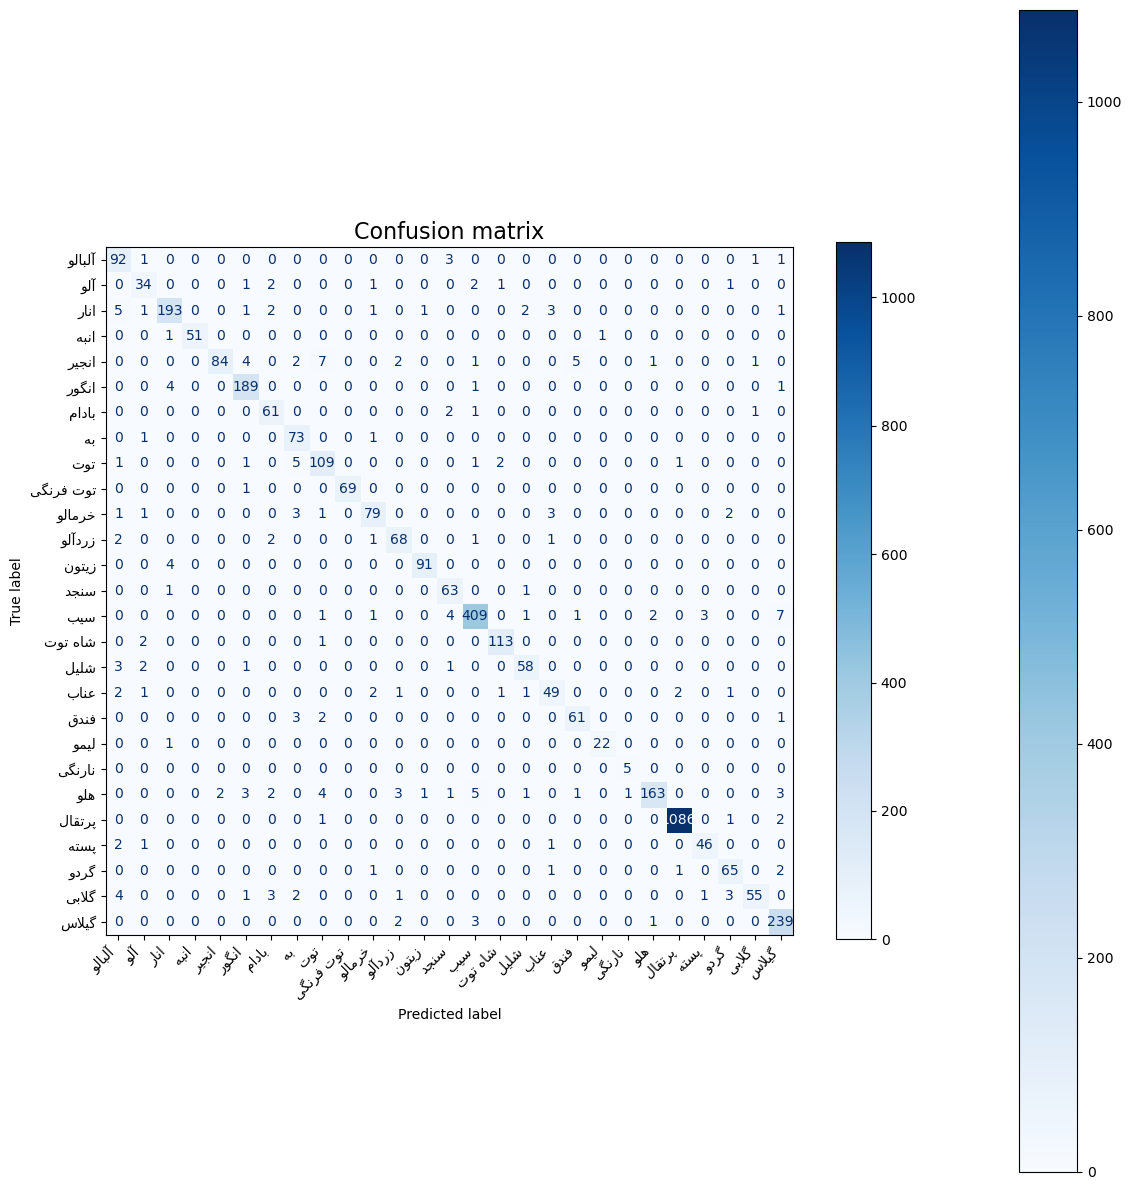

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# تغییر شکل و راست به چپ کردن لیبل‌های فارسی
reshaped_labels = [get_display(arabic_reshaper.reshape(label)) for label in svm_model.classes_]

# تولید و نمایش ماتریس سردرگمی
cm = confusion_matrix(y_test, y_pred_svm, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=reshaped_labels)

# نمایش ماتریس سردرگمی با تنظیمات برای افزایش اندازه هر خانه
fig, ax = plt.subplots(figsize=(12, 12))  # افزایش اندازه کلی شکل
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')  # `values_format='d'` برای نمایش صحیح اعداد صحیح

# تنظیم سایز colorbar با استفاده از shrink
cbar = ax.figure.colorbar(disp.im_, ax=ax, shrink=0.6)  # کاهش سایز colorbar
# # اضافه کردن متن‌های داخل خانه‌ها با فونت بزرگ‌تر
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         plt.text(j, i, format(cm[i, j], 'd'),
#                  ha="center", va="center", color="black", fontsize=14)  # تنظیم اندازه فونت داخل خانه

# تنظیم عنوان و چرخش لیبل‌ها برای خوانایی بهتر
plt.title('Confusion matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')  # چرخش لیبل‌ها برای خوانایی بهتر

# تنظیم فاصله‌ها و نمایش نمودار
plt.tight_layout()
plt.show()


In [20]:
svm_model_scaled = SVC(kernel='linear', random_state=42, probability=True, class_weight='balanced')
svm_model_scaled.fit(X_train_scaled, y_train)

# Step 6: Evaluate the model
y_pred_svm_scaled = svm_model_scaled.predict(X_test_scaled)

# Print accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_svm_scaled))
# Print classification report
print(classification_report(y_test, y_pred_svm_scaled))

Accuracy: 0.9
              precision    recall  f1-score   support

     albaloo       0.87      0.87      0.87        98
        aloo       0.61      0.67      0.64        42
       anaab       0.83      0.77      0.80       122
        anar       0.97      0.76      0.85       188
      angoor       0.89      0.94      0.92       200
       anjir       0.81      0.95      0.87        75
      badoom       0.69      0.86      0.76        85
         beh       0.73      0.85      0.79       100
     fandogh       0.92      0.90      0.91        60
      gerdoo       0.88      0.93      0.90        55
      gilaas       0.88      0.92      0.90       260
      golabi       0.75      0.90      0.82        50
       holoo       0.87      0.83      0.85       190
    khormalu       0.90      0.86      0.88       110
       lemon       1.00      0.95      0.97        40
       mango       0.97      1.00      0.99        35
      orange       0.99      0.99      0.99      1120
      pesteh 

In [33]:
estimators = [
    ('rf', rf_classifier),
    ('svm', svm_model)
]

# Initialize Stacking Classifier
stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(solver='lbfgs', max_iter=400))

# Train the stacked model
stack_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_stack = stack_clf.predict(X_test)

# Evaluate the classifier
accuracy_stack = accuracy_score(y_test, y_pred_stack)
report_stack = classification_report(y_test, y_pred_stack)

print(f"Stacking Classifier Accuracy: {accuracy_stack:.4f}")
print(report_stack)

Stacking Classifier Accuracy: 0.9513
              precision    recall  f1-score   support

      آلبالو       0.84      0.94      0.89        98
         آلو       0.87      0.79      0.82        42
        انار       0.96      0.92      0.94       210
        انبه       1.00      0.96      0.98        53
       انجیر       0.99      0.76      0.86       107
       انگور       0.91      0.97      0.94       195
       بادام       0.92      0.94      0.93        65
          به       0.86      0.96      0.91        75
         توت       0.90      0.89      0.90       120
   توت فرنگی       1.00      0.97      0.99        70
      خرمالو       0.94      0.90      0.92        90
      زردآلو       0.90      0.92      0.91        75
       زیتون       0.97      0.96      0.96        95
        سنجد       0.89      0.95      0.92        65
         سیب       0.96      0.97      0.96       429
     شاه توت       0.95      0.98      0.97       116
        شلیل       0.90      0.88      0.89 

In [37]:
import pickle
with open('stacking_classifier.pkl', 'wb') as model_file:
    pickle.dump(stack_clf, model_file)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# تغییر شکل و راست به چپ کردن لیبل‌های فارسی
reshaped_labels = [get_display(arabic_reshaper.reshape(label)) for label in svm_model.classes_]

# تولید و نمایش ماتریس سردرگمی
cm = confusion_matrix(y_test, y_pred_svm, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=reshaped_labels)

# نمایش ماتریس سردرگمی با تنظیمات برای افزایش اندازه هر خانه
fig, ax = plt.subplots(figsize=(12, 12))  # افزایش اندازه کلی شکل
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')  # `values_format='d'` برای نمایش صحیح اعداد صحیح

# تنظیم سایز colorbar با استفاده از shrink
cbar = ax.figure.colorbar(disp.im_, ax=ax, shrink=0.6)  # کاهش سایز colorbar
# # اضافه کردن متن‌های داخل خانه‌ها با فونت بزرگ‌تر
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         plt.text(j, i, format(cm[i, j], 'd'),
#                  ha="center", va="center", color="black", fontsize=14)  # تنظیم اندازه فونت داخل خانه

# تنظیم عنوان و چرخش لیبل‌ها برای خوانایی بهتر
plt.title('Confusion matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')  # چرخش لیبل‌ها برای خوانایی بهتر

# تنظیم فاصله‌ها و نمایش نمودار
plt.tight_layout()
plt.show()


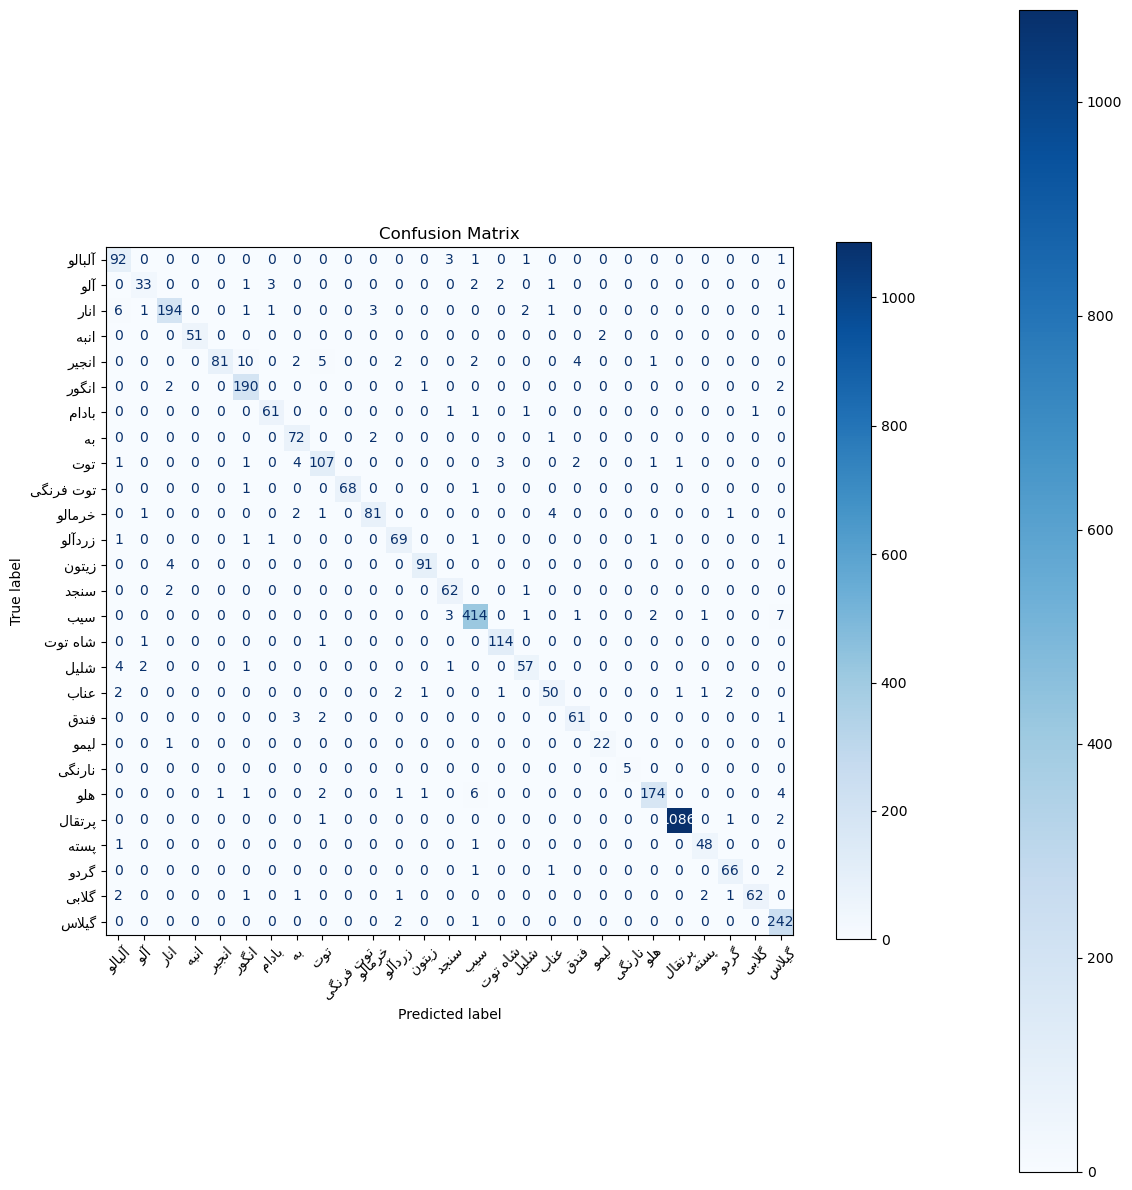

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# تغییر شکل و راست به چپ کردن لیبل‌های فارسی
reshaped_labels = [get_display(arabic_reshaper.reshape(label)) for label in stack_clf.classes_]
# Step 5: Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_stack, labels=stack_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=reshaped_labels)

fig, ax = plt.subplots(figsize=(12, 12))  # افزایش اندازه کلی شکل
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')

cbar = ax.figure.colorbar(disp.im_, ax=ax, shrink=0.6)
plt.title('Confusion Matrix')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.tight_layout()
plt.show()

In [22]:
# Create a VotingClassifier with the trained models
voting_clf = VotingClassifier(estimators, voting='soft')

# Train the VotingClassifier (it will use the already trained models internally)
voting_clf.fit(X_train, y_train)

# Predict on the test set with VotingClassifier
y_pred_voting = voting_clf.predict(X_test)

# Evaluate the ensemble model
print("Accuracy:", accuracy_score(y_test, y_pred_voting))
print("Classification Report:\n", classification_report(y_test, y_pred_voting, zero_division=0))


Accuracy: 0.9380208333333333
Classification Report:
               precision    recall  f1-score   support

     albaloo       0.92      0.92      0.92        98
        aloo       0.84      0.74      0.78        42
       anaab       0.91      0.82      0.86       122
        anar       0.96      0.80      0.87       188
      angoor       0.93      0.96      0.95       200
       anjir       0.87      0.92      0.90        75
      badoom       0.81      0.88      0.84        85
         beh       0.93      0.93      0.93       100
     fandogh       0.89      0.92      0.90        60
      gerdoo       0.96      0.91      0.93        55
      gilaas       0.95      0.96      0.95       260
      golabi       0.87      0.96      0.91        50
       holoo       0.94      0.93      0.93       190
    khormalu       0.93      0.90      0.91       110
       lemon       1.00      0.95      0.97        40
       mango       0.94      0.91      0.93        35
      orange       0.99     

In [23]:
# Separate features and labels
X = df.iloc[:, :-2].values
y = df['label'].values

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert labels to categorical
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

# Function to split data in blocks of 5
def block_split(X, y, block_size=5, test_size=0.2):
    n_samples = X.shape[0]
    indices = np.arange(0, n_samples, block_size)
    test_indices = np.random.choice(indices, size=int(len(indices) * test_size), replace=False)
    train_indices = np.setdiff1d(indices, test_indices)

    train_X, test_X = [], []
    train_y, test_y = [], []

    for idx in train_indices:
        train_X.extend(X[idx:idx+block_size])
        train_y.extend(y[idx:idx+block_size])

    for idx in test_indices:
        test_X.extend(X[idx:idx+block_size])
        test_y.extend(y[idx:idx+block_size])

    return np.array(train_X), np.array(test_X), np.array(train_y), np.array(test_y)

# Split the data
X_train_NN, X_test_NN, y_train_NN, y_test_NN = block_split(X, y)

# Define the neural network
model = Sequential([
    Dense(256, activation='relu', input_shape=(512,)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_NN, y_train_NN, epochs=50, batch_size=32, validation_data=(X_test_NN, y_test_NN))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_NN, y_test_NN)
print(f'Test Accuracy: {accuracy}')


Epoch 1/50
480/480 [==============================] - 10s 8ms/step - loss: 2.2500 - accuracy: 0.3856 - val_loss: 1.6841 - val_accuracy: 0.5179
Epoch 2/50
480/480 [==============================] - 2s 4ms/step - loss: 1.7644 - accuracy: 0.4701 - val_loss: 1.4929 - val_accuracy: 0.5533
Epoch 3/50
480/480 [==============================] - 2s 4ms/step - loss: 1.5783 - accuracy: 0.5189 - val_loss: 1.3497 - val_accuracy: 0.5833
Epoch 4/50
480/480 [==============================] - 2s 3ms/step - loss: 1.4513 - accuracy: 0.5517 - val_loss: 1.2350 - val_accuracy: 0.6250
Epoch 5/50
480/480 [==============================] - 2s 3ms/step - loss: 1.3468 - accuracy: 0.5803 - val_loss: 1.1319 - val_accuracy: 0.6529
Epoch 6/50
480/480 [==============================] - 2s 4ms/step - loss: 1.2849 - accuracy: 0.5953 - val_loss: 1.0434 - val_accuracy: 0.6720
Epoch 7/50
480/480 [==============================] - 2s 4ms/step - loss: 1.2265 - accuracy: 0.6135 - val_loss: 1.0297 - val_accuracy: 0.6785
Epoch

In [31]:
warnings.filterwarnings('ignore', category=UserWarning)
# Function to load and preprocess a single image
def process_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Extract features for a single image
def extract_features_single(image_path, feature_extractor):
    image = process_image(image_path, transform)
    with torch.no_grad():
        features = feature_extractor(image)
    return features.numpy().flatten()

# Example usage
def extract_features_from_folder(folder_path, feature_extractor):
    cnt = 0
    corr =0
    for filename in os.listdir(folder_path):
        cnt +=1
        image_path = os.path.join(folder_path, filename)
        features = extract_features_single(image_path, feature_extractor)
        data_features = features.reshape(1, -1)
        # print(len(features[0]))
        prediction = svm_model.predict(data_features)
        print(f"Predicted class for the new sample: {prediction[0]}")
        if prediction[0] == 'angoor':
            corr += 1
    print(cnt)
    return corr/cnt

# Example usage
folder_path = 'test'
percision = extract_features_from_folder(folder_path, feature_extractor)
print(percision)

Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted class for the new sample: angoor
Predicted c

In [33]:
image_path = 'test/18-05-h-image (3).JPG'
features = extract_features_single(image_path, feature_extractor)
# print(type(features))

data_features = features.reshape(1, -1)
prediction = stack_clf.predict(data_features)
print(f"Predicted class for the new sample: {prediction[0]}")


Predicted class for the new sample: angoor
